In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [3]:
def bb_pad_collate(samples:BatchSamples, pad_idx:int=2) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    samples = [s for s in samples if s[1].data[0].shape[0] > 0] # check that labels are available

    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        bboxes[i,-len(lbls):] = bbs
        labels[i,-len(lbls):] = lbls
    return torch.cat(imgs,0), (bboxes,labels)

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [5]:
images, lbl_bbox = get_annotations(path/'WhiteBloodCellCoco.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [6]:
data = (ObjectItemList.from_folder(path, extensions='.bmp')
        #Where are the images? -> in coco
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=256)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate

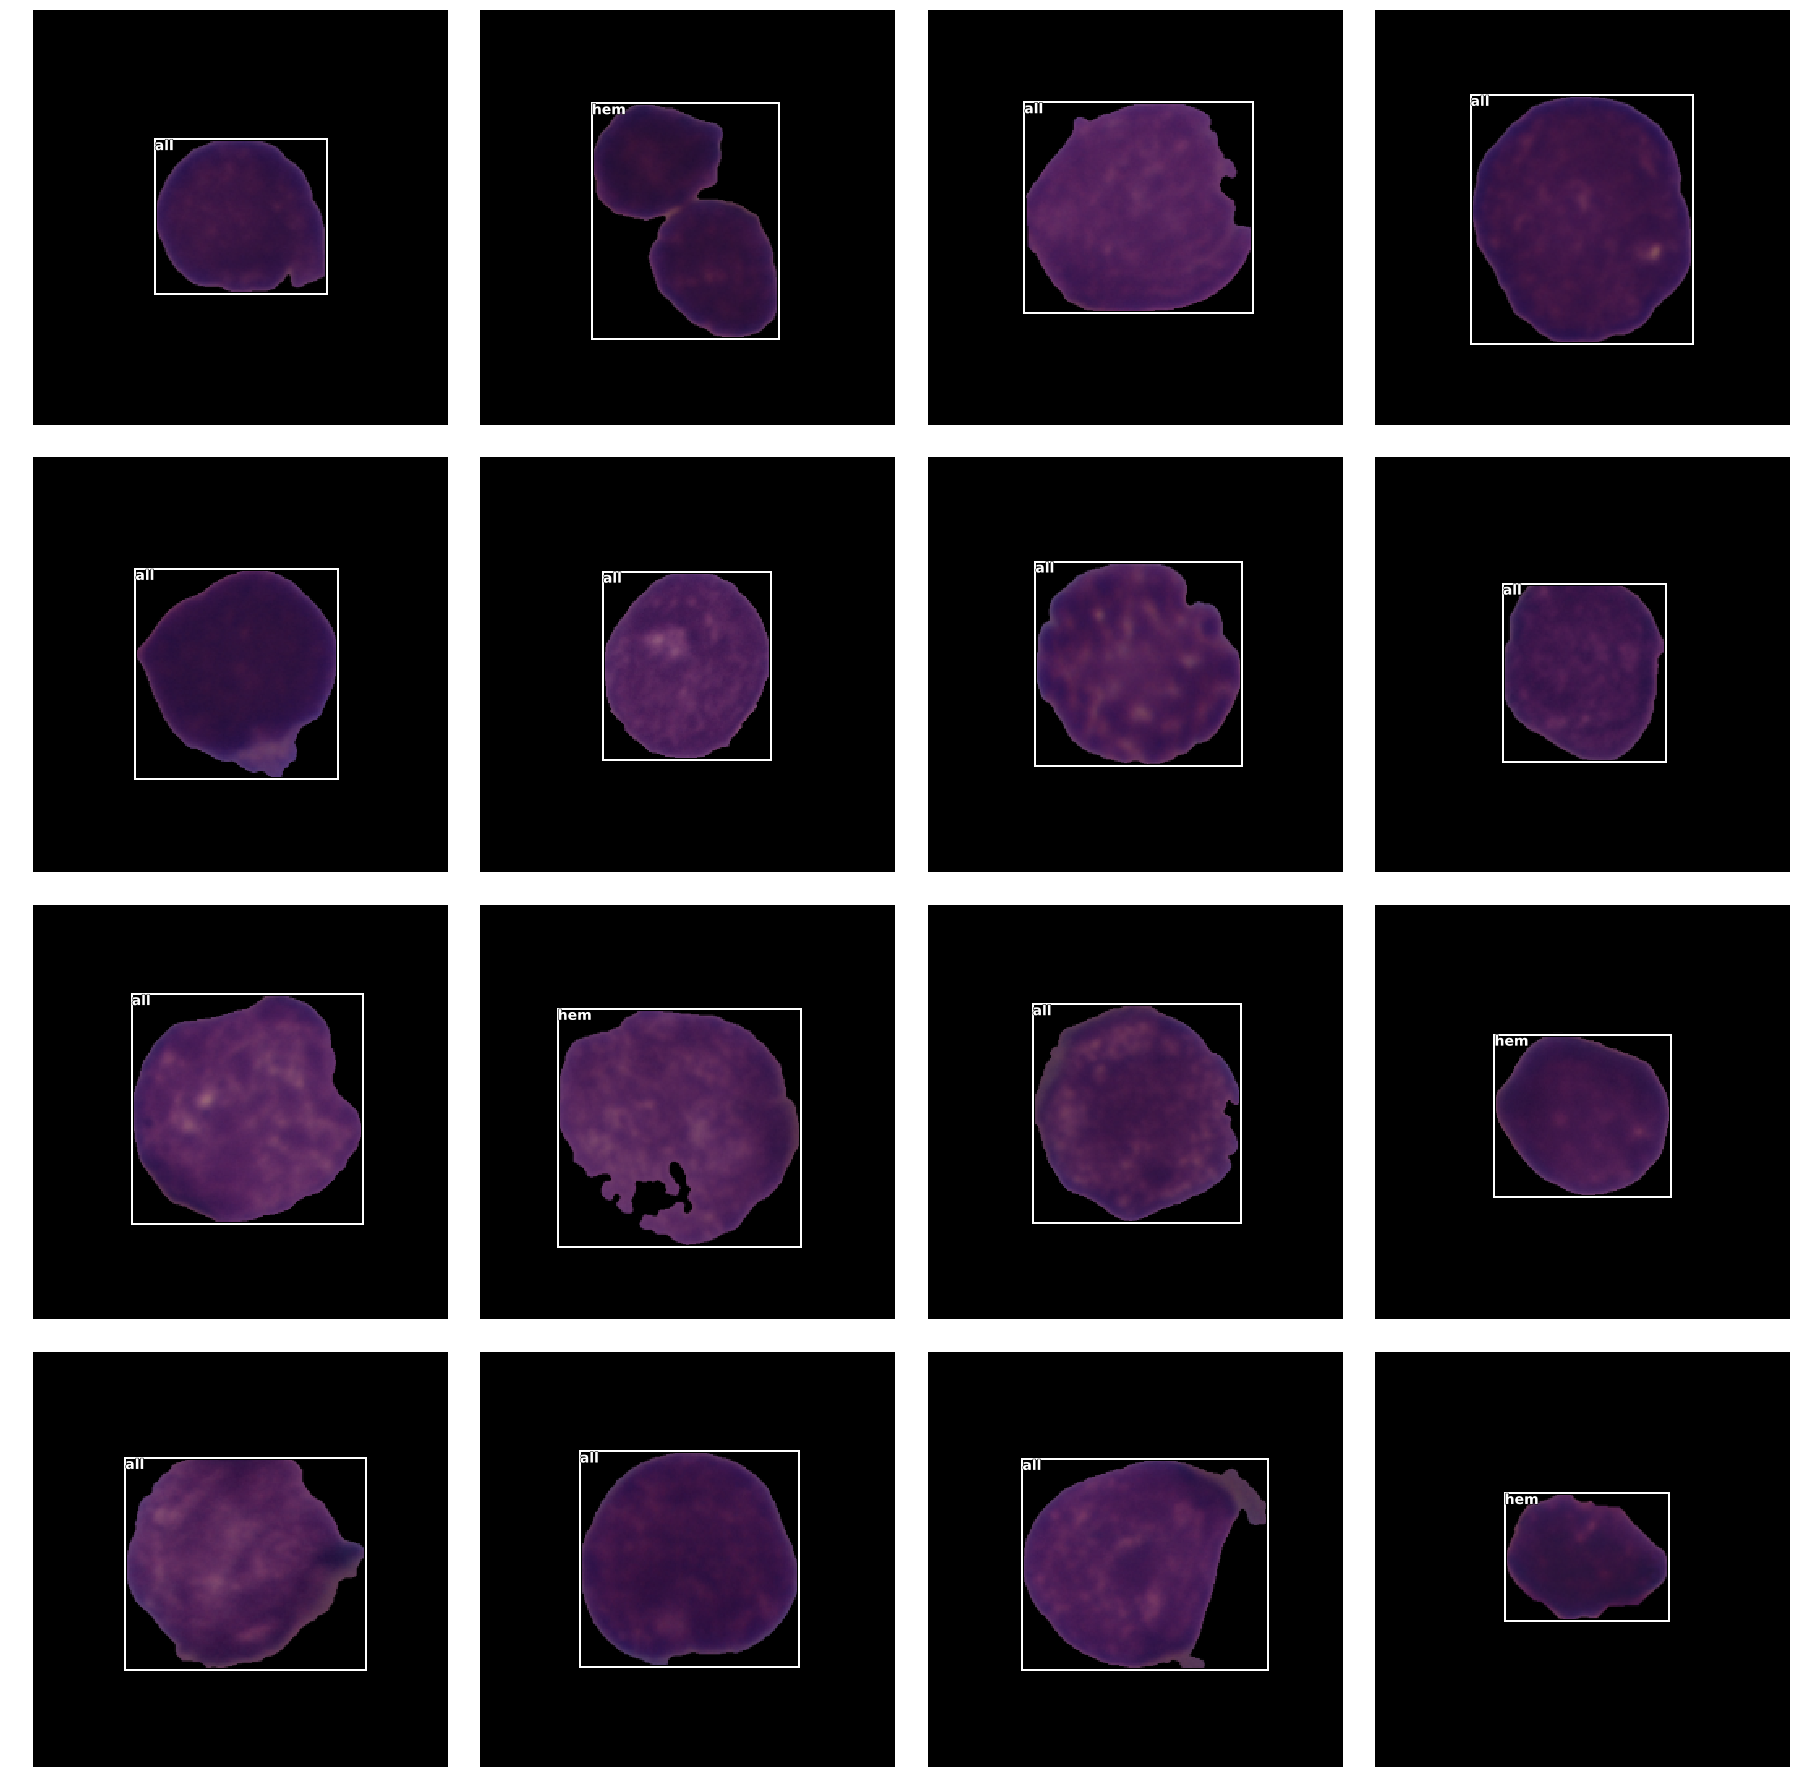

In [8]:
data.show_batch(rows=4, ds_type=DatasetType.Valid, figsize=(25,25))